In [6]:
import numpy
import pandas
from numpy import matrix, linalg, linspace, interp, asarray, argmax
from scipy.integrate import odeint
from scipy.stats import linregress 
import matplotlib.pyplot as plt
%matplotlib inline

### Tutorial 8


We will continue with the _A.succinogenes_ example of tut 5.

<img src="succmap_num.png" width="550" />

The fluxes are numbered in the figure above and the first seven equations of the model is supplied in hidden format in [Tut8eq.xlsx](https://github.com/willienicol/Biochemical-engineering-notes/blob/master/Tutorials/Tut8eq.xlsx). Equation 7 represents the energy balance. All equations are equal to zero except the energy balance that is equal to $\theta$. All rates correspond to the flux numbers on the map.

You can use your own model or the supplied model. Assume the absence of pyruvate formate lyase (PFL). 

The physiological parameters can be taken as:

|$\alpha \qquad \qquad$|$\gamma \qquad \qquad $|$\mu \qquad$|$\theta\qquad$
|----|-|-|-|-
|$\frac{\text{cmol $CO_2$}}{\text{cmol X}}$|$\frac{\text{mol ATP}}{\text{cmol X}}$|$\frac{1}{\text{h}}$|$\frac{\text{mol ATP}}{\text{cmol X}\cdot \text{h}}$
|0.12|1.8|0.15|0.1

The biomass formula is given by $CH_{1.9}O_{0.45}N_{0.23}$

It is easy to transfer the $7 \times 9$ matrix into Python and add specification equations. You can use the code below. Ensure that the Excel file is in the same directory as the Jupyter notebook file.
import pandas, numpy
S = numpy.matrix(pandas.read_excel('Tut8eq.xlsx'))
S1 = numpy.vstack([S,[0,1,0,0,0,0,0,0,0],[0,0,0,0,0,0,1,0,0]]) # Adding mu and zero PFL spec.

a) Given an initial glucose concentration of 100 $\frac{\text{g}}{\text{L}}$ and biomass concentration of 0.001 $\frac{\text{cmol X}}{\text{L}}$, determine the time required to convert all the glucose. [43.9h] 

In [7]:
alpha, beta, gamma = 0.12, 0.085, 1.80

In [8]:
def response_fun(C):
    if C[1]<=0:               # glucose concentration
        return [0,0,0,0,0]      # all zero rates when there is no glucose
            
    else:
        mu, theta= 0.15, 0.10
                
        import pandas, numpy
        S = numpy.matrix(pandas.read_excel('Tut8eq.xlsx'))
        S1 = numpy.vstack([S,[0,1,0,0,0,0,0,0,0],[0,0,0,0,0,0,1,0,0]]) # Adding mu and zero PFL spec.

        K = numpy.matrix([0, 0, 0, 0, 0, 0, theta, mu, 0]).T
        r = numpy.linalg.solve(S1, K) 
        
    
        return [r[1,0],   # important to see the order of the rates (X,S,SA,F,A)
               -r[0,0],   # glucose, note the negative since the flux model calculated (-rs)
                r[5,0],   # Succinic acid
                r[6,0],   # Fumarate
                r[8,0]]   # Acetic Acid

In [9]:
def ferm_eq(C,t):
    Cx, Cs, Csa, Cf, Ca = C[0],C[1],C[2],C[3],C[4]  # order of components very important 
    r=response_fun([Cx, Cs, Csa, Cf, Ca])      # this is the 'fetching' from the response function
    
    return [r[0]*Cx,
            r[1]*Cx,    
            r[2]*Cx,
            r[3]*Cx,
            r[4]*Cx]

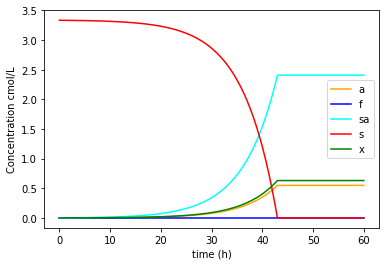

In [10]:
Co=[0.001, 100/30,0,0,0]                   # [Cxo, Cso, Csao, Cfo, Cao] in cmol/L
tmax=60                                 # Integrate for 20 hours  
tspan=numpy.linspace(0,tmax,500)           # define the timespan of the integration
C = odeint(ferm_eq, Co, tspan)             # integration via odeint that calls upon ferm_eq

Cx, Cs, Csa, Cf, Ca = C.T

plt.plot(tspan, Ca, color='orange', label='a')
plt.plot(tspan, Cf, color='blue', label='f')
plt.plot(tspan, Csa, color='cyan', label='sa')
plt.plot(tspan, Cs, color='red',label='s')
plt.plot(tspan, Cx, color='green',label='x')
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('time (h)') 
plt.show()



In [11]:
#the fermentation process proceeds untill gluc is fully consumed - i.e when Cs = 0

t_nogluc = interp(0,Cs[::-1],tspan[::-1])
print ('Glucose will be totally converted by ', t_nogluc, 'hours')

Glucose will be totally converted by  43.046092147232144 hours


b) Determine the yield of succinic acid on glucose in $\frac{cmol}{cmol}$ by taking the amount of glucose converted and succininc acid formed throughout the whole run. How does this compare to the yields that the stoichiometric matrix predict and why? [0.722]

In [12]:
i = numpy.argmax(Cs == min(Cs)) #give index of zero gluc
Ysa = Csa[i]/Co[1]
print('Ysa=',Ysa,'cmolSA/cmolGluc')

Ysa= 0.7223827795052017 cmolSA/cmolGluc


Although stoichiometry implies a fixed ratio of production between products and a reagent, the amount of PEP going towards Aca and the other going to SA is not fixed - they are two separate reactions. Also, the rates are not constant, they change over time as the concentrations in the fermenter change.


c) Solve analytically for the biomass equation in the fermenter equation and plot against the answer obtained in (a). Integrate up to 45 hours. Why is it possible to solve for the biomass profile separately? At what point in time does the two profiles vary and why? 


The equation linking $\mu$ to $C_X$ is the following:

$$\frac{dC_X}{dt}=\mu C_X $$  

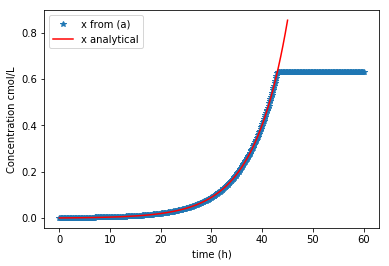

In [13]:
mu=0.15
def biomass(C,t):
    C=C[0]
    return [mu*C]
           
                      
tmax1=45                                     
tspan1=numpy.linspace(0,tmax1,100)           
C_xeq = odeint(biomass, Co[0], tspan1)             

plt.plot(tspan, Cx, '*',label='x from (a)')
plt.plot(tspan1, C_xeq, color='red',label='x analytical')
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('time (h)') 
plt.show()

We can solve for biomass separately because while there is glucose, the increase in concentration can be predicted. It differs fromm the actual, because in the actual profile, glucose runs out and the concentrations of all the species can no longer change.


d) Plot the rate of succinic acid production ($r_{SA}$) against time and comment.

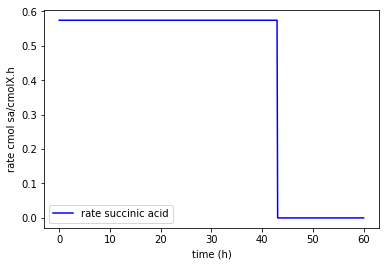

In [14]:
rates = numpy.asarray([response_fun(x) for x in C])
rsa = rates[:, 2]

plt.plot(tspan, rsa, color='blue',label='rate succinic acid')   
#plt.plot(tspan, rates)
plt.legend(loc='best')
plt.ylabel('rate cmol sa/cmolX.h') 
plt.xlabel('time (h)') 
plt.show()


The rate of succinic acid is a ratio of cmol SA per cmol X which remains constant, hence the flat line.


e) Plot the volumetric rate of succininc acid production ($r^V_{SA}$) against time and comment.

<img src="tut8e.png" width="500" />

Apart from the cmol based rates ($r_i$) we'll define a volumetric rate ($r^V_i$) as follow:


$$r^V_i=r_i \cdot C_X $$
------------

$$\left[ \frac{cmol\,i}{L \cdot h} \right] = 
\left[ \frac{cmol\,i}{cmol\,X\cdot h} \cdot \frac{cmol\,X}{L} \right] $$

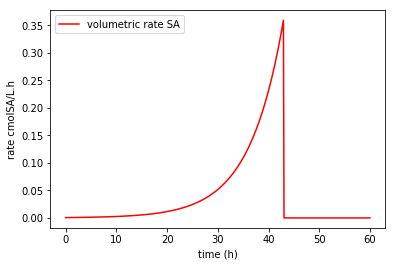

In [15]:
rates1 = numpy.asarray([ferm_eq(y,tspan) for y in C])
rsav = rates1[:, 2]

plt.plot(tspan, rsav, color='red',label='volumetric rate SA')   
#plt.plot(tspan, rates1)
plt.legend(loc='best')
plt.ylabel('rate cmolSA/L.h') 
plt.xlabel('time (h)') 
plt.show()

Although the rate stays constant, the volumetric flow rate is a function of the concentration change. So in this graph, the rsa stays constant but the concentration of biomass increases thereby increasing the volumetric rate of SA as per the equation.


f) If the initial biomass concentration is changed to 0.0001 $\frac{\text{cmol X}}{\text{L}}$, how long will it take to convert all the glucose? [58.4h] 

In [16]:
Co1=[0.0001, 100/30,0,0,0]              # [Cxo, Cso, Csao, Cfo, Cao] in cmol/L
tmax1=60                                 # Integrate for 20 hours  
tspan1=numpy.linspace(0,tmax1,500)        # define the timespan of the integration
C1 = odeint(ferm_eq, Co1, tspan1)        # integration via odeint that calls upon ferm_eq

Cx1, Cs1, Csa1, Cf1, Ca1 = C1.T

t_nogluc1 = interp(0,Cs1[::-1],tspan1[::-1])
print ('Glucose will be totally converted by ', t_nogluc1, 'hours')

Glucose will be totally converted by  58.31663326118249 hours



g) Change the glucose initial concentration to 60 $\frac{\text{g}}{\text{L}}$ and determine how long it will take to convert all the glucose by using $C^O_X$ of (f)? [55.2h]  

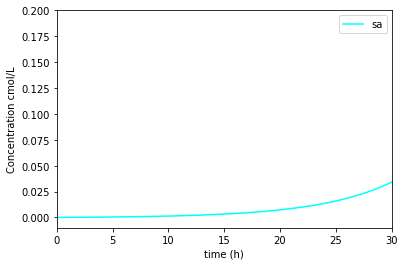

Glucose will be totally converted by  54.94989956819042 hours


In [17]:
Co2=[0.0001, 60/30,0,0,0]              # [Cxo, Cso, Csao, Cfo, Cao] in cmol/L
tmax2=60                                 # Integrate for 20 hours  
tspan2=numpy.linspace(0,tmax2,500)        # define the timespan of the integration
C2 = odeint(ferm_eq, Co2, tspan2)        # integration via odeint that calls upon ferm_eq

Cx2, Cs2, Csa2, Cf2, Ca2 = C2.T

plt.plot(tspan, Csa2, color='cyan', label='sa')
plt.axis([0,30,-0.01,0.20])
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('time (h)') 
plt.show()

t_nogluc2 = interp(0,Cs2[::-1],tspan2[::-1])
print ('Glucose will be totally converted by ', t_nogluc2, 'hours')



h) For the conditions in (g), what is the succininc acid concentration in $\frac{cmol}{L}$ after 20 hours? [0.692]

In [18]:
SAconc = interp(20,tspan2,Csa2)
print ('SA Concentration after 20hrs=',SAconc,'cmolSA/L')

SA Concentration after 20hrs= 0.007305569700731786 cmolSA/L


From SA conc graph above, I don't think the given answer of 0.692 is correct. 


i) Assume that $\theta=0$ and determine how long will it take to convert all the glucose by using the conditions of (g). Comment on your answer.[56.6h] 

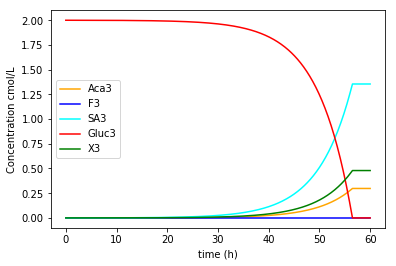

Glucose will be totally converted by  56.51302581371569 hours


In [19]:
def response_fun3(C):
    if C[1]<=0:               # glucose concentration
        return [0,0,0,0,0]      # all zero rates when there is no glucose
            
    else:
        mu, theta= 0.15, 0.00
                
        import pandas, numpy
        S = numpy.matrix(pandas.read_excel('Tut8eq.xlsx'))
        S1 = numpy.vstack([S,[0,1,0,0,0,0,0,0,0],[0,0,0,0,0,0,1,0,0]]) # Adding mu and zero PFL spec.

        K = numpy.matrix([0, 0, 0, 0, 0, 0, theta, mu, 0]).T
        r = numpy.linalg.solve(S1, K) 
        
    
        return [r[1,0],   # important to see the order of the rates (X,S,SA,F,A)
               -r[0,0],   # glucose, note the negative since the flux model calculated (-rs)
                r[5,0],   # Succinic acid
                r[6,0],   # Fumarate
                r[8,0]]   # Acetic Acid

def ferm_eq3(C,t):
    Cx3, Cs3, Csa3, Cf3, Ca3 = C[0],C[1],C[2],C[3],C[4]  # order of components very important 
    r=response_fun3([Cx3, Cs3, Csa3, Cf3, Ca3])      # this is the 'fetching' from the response function
    
    return [r[0]*Cx3,
            r[1]*Cx3,    
            r[2]*Cx3,
            r[3]*Cx3,
            r[4]*Cx3]

Co3=[0.0001, 60/30,0,0,0]                   # [Cxo, Cso, Csao, Cfo, Cao] in cmol/L
tmax3=60                                 # Integrate for 20 hours  
tspan3=numpy.linspace(0,tmax3,500)           # define the timespan of the integration
C3 = odeint(ferm_eq3, Co3, tspan3)             # integration via odeint that calls upon ferm_eq

Cx3, Cs3, Csa3, Cf3, Ca3 = C3.T

plt.plot(tspan, Ca3, color='orange', label='Aca3')
plt.plot(tspan, Cf3, color='blue', label='F3')
plt.plot(tspan, Csa3, color='cyan', label='SA3')
plt.plot(tspan, Cs3, color='red',label='Gluc3')
plt.plot(tspan, Cx3, color='green',label='X3')
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('time (h)') 
plt.show()

t_nogluc3 = interp(0,Cs3[::-1],tspan3[::-1])
print ('Glucose will be totally converted by ', t_nogluc3, 'hours')

When $\theta=0$ is changed to 0, the answer in g) changes to 56.51hrs. There's is less ATP generated (lower concentration)therefore the production will be slower until glucose runs out.


j) Plot the succininc acid profiles of (g) and (i) on the same graph and comment.

<img src="tut8j.png" width="500" />

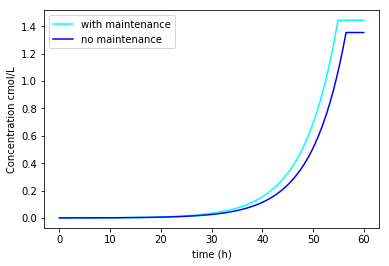

In [20]:
plt.plot(tspan2, Csa2, color='cyan',label='with maintenance')
plt.plot(tspan3, Csa3, color='blue',label='no maintenance')
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('time (h)') 
plt.show()